# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision.datasets import ImageFolder
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from my_utils.folder2lmdb import ImageFolderLMDB
from torchvision import transforms

import time
import datetime



/home/aai/anaconda3/envs/stylegan2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


def accumulate(model1, model2, decay=0.999): # g_ema(exponential moving average) 계산을 위한 함수
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(par2[k].data, alpha=1 - decay)

def prepare_dataloader(args):
    my_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize(args.img_size),
        transforms.CenterCrop(args.center_crop),
        transforms.Resize(args.img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
    ]
    )
    lmdb_ImageFolder = ImageFolderLMDB
    train_dataset = lmdb_ImageFolder(args.train_path, transform = my_transform)
    test_dataset = lmdb_ImageFolder(args.test_path, transform = my_transform)

    train_loader = DataLoader(
        train_dataset,
        batch_size=args.batch,
        sampler=data_sampler(train_dataset, shuffle=True, distributed=False),
        drop_last=True,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=args.batch,
        sampler=data_sampler(test_dataset, shuffle=False, distributed=False),
        drop_last=True,
    )
    for idx, (image,label) in enumerate(train_loader):
        print(f"image : {image.shape}")
        print(f"label : {label.shape} {label[:10]}")
        break

    plt.figure(figsize=(15, 2), dpi=100)
    for idx, (image,label) in enumerate(test_loader):
        plt.subplot(1,10, idx+1)
        plt.title(num_to_label(label[idx].item())) ; plt.axis('off')
        plt.imshow(denorm(to_np(image[idx].permute(1,2,0))))
        if idx == 9:
            break
        
    return train_loader, test_loader, image, label

def data_sampler(dataset, shuffle, distributed):
    if distributed:
        return data.distributed.DistributedSampler(dataset, shuffle=shuffle)

    if shuffle:
        return data.RandomSampler(dataset)

    else:
        return data.SequentialSampler(dataset)

def to_np(tensor):
    return tensor.cpu().detach().numpy()

def denorm(tensor):
    return (tensor + 1)/2

def num_to_label(num):
    return 'smile' if num == 1 else 'non-smile'



# Train

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda device : cuda:2
오늘 날짜 : 2022-05-18
cuda device : cuda:2
n_gpu : 1


/tmp/ipykernel_2181567/1097421160.py:21: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  train_loader, test_loader, image, label = prepare_dataloader(args)
/home/aai/anaconda3/envs/stylegan2/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py:49: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  data = [self.dataset[idx] for idx in possibly_batched_index]


image : torch.Size([32, 3, 64, 64])
label : torch.Size([32]) tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 1])


/mnt/aai/song/MyStylegan2/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu111. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


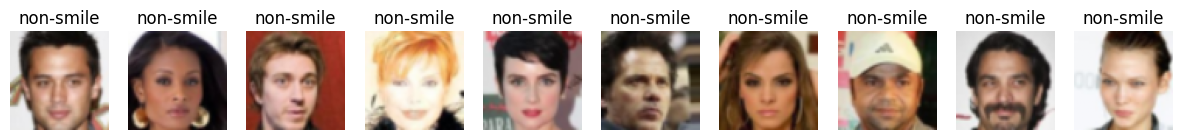

In [6]:
%load_ext autoreload
%autoreload 2
import os
from my_models import *
from my_train import * 
from pretrain_encoder import ResidualBlock, ResNet

import args
import wandb

today = datetime.date.today()
device = torch.device(f"cuda:{args.gpu_num}" if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print(f'오늘 날짜 : {today}')
print(f'cuda device : {device}')

n_gpu = int(os.environ["WORLD_SIZE"]) if "WORLD_SIZE" in os.environ else 1
print(f"n_gpu : {n_gpu}")
args.distributed = n_gpu >= 2 

train_loader, test_loader, image, label = prepare_dataloader(args)


E = ResNet(return_features=True).to(device)
E.load_state_dict(torch.load("pretrained/classifier/ResNet_64_parameters_smiling.pt"))
pred, feat_list = E(image.to(device))
G = Generator(feat_list, size=args.img_size, style_dim=args.latent).to(device)
_, styles = G(feat_list)
D = Discriminator(args.img_size, args.latent).to(device)
g_ema = Generator(feat_list, size=args.img_size, style_dim=args.latent).to(device)
P = Predictor(styles).to(device)

g_ema.eval()
accumulate(g_ema, G, 0)

from torch import nn, optim
e_reg_ratio = args.d_reg_every / (args.d_reg_every + 1)
g_reg_ratio = args.g_reg_every / (args.g_reg_every + 1)
d_reg_ratio = args.d_reg_every / (args.d_reg_every + 1)

recon_optim = optim.Adam(G.parameters(),lr=args.lr * g_reg_ratio, betas=(0 ** g_reg_ratio, 0.99 ** g_reg_ratio))
g_optim = optim.Adam(G.parameters(), lr=args.lr * g_reg_ratio, betas=(0 ** g_reg_ratio, 0.99 ** g_reg_ratio))
d_optim = optim.Adam(D.parameters(), lr=args.lr * d_reg_ratio, betas=(0 ** d_reg_ratio, 0.99 ** d_reg_ratio))
p_optim = optim.Adam(P.parameters(), lr=args.lr * g_reg_ratio, betas=(0 ** g_reg_ratio, 0.99 ** g_reg_ratio))


In [7]:
if args.ckpt is not None:
    print("load model:", args.ckpt)

    ckpt = torch.load(args.ckpt, map_location=lambda storage, loc: storage)

    try:
        ckpt_name = os.path.basename(args.ckpt)
        args.start_iter = int(os.path.splitext(ckpt_name)[0])

    except ValueError:
        pass

    E.load_state_dict(ckpt["e"])
    G.load_state_dict(ckpt["g"])
    D.load_state_dict(ckpt["d"])
    g_ema.load_state_dict(ckpt["g_ema"])
    recon_optim.load_state_dict(ckpt["recon_optim"])
    g_optim.load_state_dict(ckpt["g_optim"])
    d_optim.load_state_dict(ckpt["d_optim"])


if args.wandb:
    wandb.init(project="StyleGAN2", entity='songyj', name=args.description,
               config=get_config_from_args(args))
torch.autograd.set_detect_anomaly(False)
train(args, train_loader, test_loader, E, G, D, P, recon_optim, p_optim, g_optim, d_optim, g_ema, today, device)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: songyj. Use `wandb login --relogin` to force relogin


  0%|          | 0/800000 [00:00<?, ?it/s]/home/aai/anaconda3/envs/stylegan2/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py:49: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  data = [self.dataset[idx] for idx in possibly_batched_index]
/mnt/aai/song/MyStylegan2/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.1+cu111. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
/home/aai/anaconda3/envs/stylegan2/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
d: 0.1123; g: 2.8633; p: 0.7044; r1: 0.0089; path: 15.4356; mean path: 0.1278; p: 0.0005; recon_loss: 23.7996;:   0%|          | 15/800000 [02:35<2253:43:54, 10.14s/it]

# Debug